In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

import nearest_neighbors
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
SENTENCES_PATH = "data/stimuli_384sentences.txt"
ENCODINGS = ["CoLA", "MNLI", "QQP", "RTE", "SNLI", "SQuAD"]

In [21]:
sentences = util.load_sentences(SENTENCES_PATH)

In [22]:
dists, dist_stats = {}, []
for encoding_name in ENCODINGS:
    print(encoding_name)
    encoding = np.load("encodings/384sentences.bert.base.finetune-5000-%s-5000.npy" % encoding_name)
    
    dists[encoding_name], dist_mean, dist_std = nearest_neighbors.eval_quant(encoding)
    dist_stats.append((encoding_name, dist_mean, dist_std))
    print()

df = pd.DataFrame(dist_stats, columns=["encoding", "avg_dist", "std_dist"]).set_index("encoding")
df

CoLA
Average pairwise distance: 0.27667847076066476
Stdev pairwise distance: 0.1852832779323698

MNLI
Average pairwise distance: 0.33212538239734857
Stdev pairwise distance: 0.06349310096802502

QQP
Average pairwise distance: 0.35020431407522495
Stdev pairwise distance: 0.06172295723753343

RTE
Average pairwise distance: 0.39362052348203147
Stdev pairwise distance: 0.08064245878940618

SNLI
Average pairwise distance: 0.31180658790345966
Stdev pairwise distance: 0.056072264058290355

SQuAD
Average pairwise distance: 0.18109800226319275
Stdev pairwise distance: 0.04150920970191947



,avg_dist,std_dist
encoding,,
CoLA,0.276678,0.185283
MNLI,0.332125,0.063493
QQP,0.350204,0.061723
RTE,0.393621,0.080642
SNLI,0.311807,0.056072
SQuAD,0.181098,0.041509


In [23]:
## TODO: Track these metrics over training time, too !

## Pairwise distance: global metrics

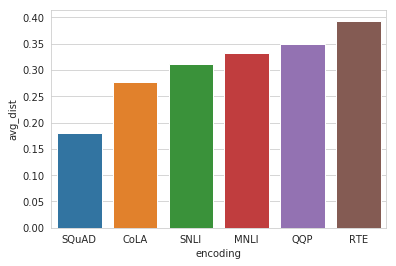

In [24]:
order = df.avg_dist.argsort()
sns.barplot(data=df.reset_index(), x="encoding", y="avg_dist", order=order.index[order])

## Pairwise distance: local evaluation

In [25]:
def argsmallest_n(a, n):
    ret = np.argpartition(a, n)[:n]
    b = np.take(a, ret)
    return np.take(ret, np.argsort(b))

In [26]:
tu = np.triu_indices(np.ceil(np.sqrt(2 * len(next(iter(dists.values()))))), 1)
def nearest_neighbor_sentences(encoding_name, n=10):
    closest = argsmallest_n(dists[encoding_name], n)
    pairs = np.column_stack((np.take(tu[0], closest),
                             np.take(tu[1], closest))) + 1
    
    ret = []
    for (s1_id, s2_id), dist_id in zip(pairs, closest):
        ret.append((dists[encoding_name][dist_id], sentences[s1_id], sentences[s2_id]))
        
    return ret

In [27]:
nearest_neighbor_sentences("CoLA")

[(0.033381329156011996,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.04894253717503372,
  'Arson is the criminal act of burning a building or wildland.',
  'A butterfly is a flying insect with four large wings.'),
 (0.05118365096033217,
  'The term is used to indicate sex distinctions relative to girls.',
  'At puberty the body of a girl develops into that of a woman.'),
 (0.05327656008766002,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.0560696611664524,
  'A desk may have drawers to store supplies and papers.',
  'A mug is thick and has a ring base for thermal insulation.'),
 (0.056114286607504726,
  'Carpenters build and repair houses, furniture, boats and other objects.',
  'Cats are small furry animals with four legs and a tail.'),
 (0.05761051540634232,
  'Lettuce is considered fairly easy to grow and a suitable c

In [28]:
nearest_neighbor_sentences("SNLI")

[(0.06791970214682264,
  'A butterfly is a flying insect with four large wings.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.0773637441320052,
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.',
  'There are many varieties of tomato, with different sizes and tastes.'),
 (0.08217728076086861,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.08608815002450709,
  'The axe usually consists of a head attached to a handle.',
  'Modern knives consist of a handle and a blade, usually made of metal.'),
 (0.08609349357825091,
  'Screwdrivers can also be used to remove screws after they are inserted.',
  'The screwdriver tip applies the torque from rotating the handle.'),
 (0.08834923312165677,
  'Carpenters build and repair houses, furniture, boats and other objects.',
  'Cats are small furry animals with four legs and 

In [29]:
nearest_neighbor_sentences("MNLI")

[(0.02490522491028424,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.07703453636887947,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.07705547893459674,
  'The term is used to indicate sex distinctions relative to girls.',
  'At puberty the body of a girl develops into that of a woman.'),
 (0.08913282215670404,
  'Arson is the criminal act of burning a building or wildland.',
  'A butterfly is a flying insect with four large wings.'),
 (0.08976477742005962,
  'Arson is the criminal act of burning a building or wildland.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.09167105755975224,
  'Girls often like playing with dolls and social games.',
  'Manhood is associated with masculinity and virility.'),
 (0.09911678248505784,
  'Female mosquitoes bite people and animals and 

In [30]:
nearest_neighbor_sentences("QQP")

[(0.06986917401497872,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.0767816159569008,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.08168490083280255,
  'Female mosquitoes bite people and animals and suck their blood for protein.',
  'Mosquito bites can spread yellow fever, malaria and other parasite diseases.'),
 (0.090916283892996,
  'Chairs consist of a seat raised above floor level, supported by legs.',
  'There are usually chairs around a table for people to sit.'),
 (0.09643503108258644,
  'Screwdrivers can also be used to remove screws after they are inserted.',
  'The screwdriver tip applies the torque from rotating the handle.'),
 (0.09893376799977383,
  'The axe usually consists of a head attached to a handle.',
  'Modern knives consist of a handle and a blade, usually made of metal.'),
 (0.09894271151293099,
 

In [31]:
nearest_neighbor_sentences("RTE")

[(0.02838827967565316,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.08534513643306951,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.09075365226459886,
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.',
  'There are many varieties of tomato, with different sizes and tastes.'),
 (0.10038061428191003,
  'Modern knives consist of a handle and a blade, usually made of metal.',
  'The small sharp points along the cutting side of the saw are called the teeth.'),
 (0.10177322310719494,
  'Female mosquitoes bite people and animals and suck their blood for protein.',
  'Mosquito bites can spread yellow fever, malaria and other parasite diseases.'),
 (0.10231098277906137,
  'Chairs consist of a seat raised above floor level, supported by legs.',
  'There are usually chairs around a table for people t

In [37]:
nearest_neighbor_sentences("SQuAD")

[(0.027955744543422534,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.038175930294760296,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.03862464317906833,
  'Arson is the criminal act of burning a building or wildland.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.041123831770839114,
  'In folklore ravens are birds of ill-omen and also tricksters.',
  'A ship is a large vehicle that floats and travels on water.'),
 (0.041201944974636806,
  'A butterfly is a flying insect with four large wings.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.043137451369787416,
  'A desk may have drawers to store supplies and papers.',
  'A mug is thick and has a ring base for thermal insulation.'),
 (0.04415510612111706,
  'Arson is the criminal act of bur

## Rank change analysis

In [32]:
encoding_preds = {}
steps = list(range(50, 5050, 50))
for encoding in ENCODINGS:
    for step in steps:
        encoding_preds[(encoding, step)] = pd.read_csv("perf.384sentences.bert.base.finetune-5000-%s-%i.pred.csv" % (encoding, step),
                                                       index_col=[0, 1])
    
encoding_preds = pd.concat(encoding_preds, names=["model", "step"])
encoding_preds.head()

rank
model step subject idx      
CoLA  50   P01     0       8
                   1      41
                   2      33
                   3      61
                   4      11

In [33]:
rank_changes = encoding_preds.reset_index().set_index(["step", "idx"]) \
    .groupby("model").apply(lambda model_preds: model_preds.groupby("idx").apply(
        lambda preds: (preds.loc[steps[-1]]["rank"] - preds.loc[steps[0]]["rank"]).mean()))
rank_changes

idx,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
model,,,,,,,,,,,,,,,,,,,,,
CoLA,14.125,18.500,32.875,2.500,16.000,10.625,25.750,28.750,60.750,33.250,...,-20.500,-0.125,-14.625,41.625,-5.125,12.375,-49.000,32.875,44.625,91.625
MNLI,39.875,6.750,-15.000,2.500,17.125,-2.625,-0.875,-8.250,27.250,-3.375,...,17.000,18.250,38.500,0.875,39.250,26.500,9.250,58.750,23.250,9.500
QQP,9.250,-25.500,-15.500,-29.750,-6.250,-5.750,-12.750,-0.375,5.000,0.000,...,-3.750,30.125,12.125,24.125,3.625,2.375,5.000,18.000,-14.000,-5.125
RTE,57.125,50.000,17.000,25.125,9.000,52.250,64.625,17.750,25.875,6.500,...,21.250,-11.125,2.000,24.625,15.375,27.250,10.500,41.000,4.750,1.750
SNLI,75.250,13.250,13.750,-13.750,7.125,-15.375,-23.500,-14.125,1.125,1.500,...,-27.500,-15.875,23.625,26.250,41.625,1.375,-25.750,23.625,10.375,-1.125
SQuAD,47.000,12.875,22.500,11.500,30.625,-12.125,1.375,1.000,10.750,3.750,...,-43.875,6.500,24.750,-1.000,9.125,27.875,13.875,40.250,1.250,7.125


In [34]:
# Change from wide to long format.
rank_changes = pd.melt(rank_changes.reset_index(), id_vars=["model"], value_name="rank_change") \
    .set_index(["model", "idx"])
rank_changes.head()

,,rank_change
model,idx,
CoLA,0,14.125
MNLI,0,39.875
QQP,0,9.250
RTE,0,57.125
SNLI,0,75.250


Text(0.5,1,'Average sentence rank change')

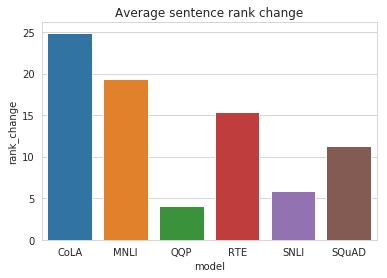

In [35]:
sns.barplot(data=rank_changes.mean(level=0).reset_index(), x="model", y="rank_change")
plt.title("Average sentence rank change")

In [40]:
n = 10

for model, rank_changes_m in rank_changes.reset_index().groupby("model"):
    print("\n\n========\n" + model)
    
    rank_changes_m = rank_changes_m.set_index("idx")
    top_sentences = rank_changes_m.index[rank_changes_m.rank_change.argsort()[::-1]]
    for sent_id in top_sentences[:n]:
        print(rank_changes_m.loc[sent_id].rank_change, sentences[sent_id])
    print()
    for sent_id in top_sentences[-n:][::-1]:
        print(rank_changes_m.loc[sent_id].rank_change, sentences[sent_id])



CoLA
246.125 Most sharks predate on fish and mammals, with powerful jaws.
162.375 Blacksmiths wears a thick apron and handle the metal with tongs.
115.25 A blacksmith creates objects by forging iron or steel.
111.625 Thieves steal to own something or to sell it to receivers.
100.375 Cats can hunt mice or birds, but are often fed by their owners.
95.875 The two major types of screwdrivers are Phillips and flathead.
95.5 A scientist creates hypotheses and does experiments to test them.
94.75 They allow bread to be cooked with toppings like garlic or cheese.
92.875 Insects have compound eyes made up of eye units facing in many directions.
91.75 Grenades can also be fired from rifles or shoulder launchers.

-50.125 A foot is a body part on the end of a leg.
-49.25 A house has a roof and walls to keep out cold and rain, and windows to let light in.
-49.125 Televisions are mostly used for watching programs or films.
-49.0 The blubber in a whale serves as an energy reservoir and as insulati